In [225]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time

In [226]:
data = pd.read_csv("./mlp_regression_data.csv");
X, y = data[["x"]].values, data["y"];

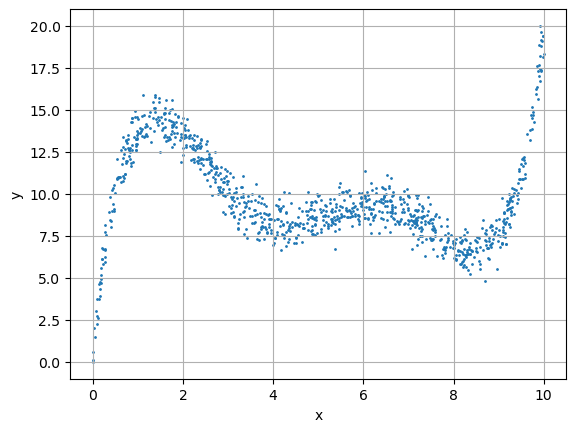

In [227]:
plt.scatter(X, y, s=1);
plt.xlabel("x");
plt.ylabel("y");
plt.grid();
plt.show();

In [228]:
class MLP(torch.nn.Module):
    def __init__(
            self, 
            numFeatures=1, 
            numClasses=1,
            activation=torch.nn.Sigmoid() # Default can be changed
        ):
        super().__init__();

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(numFeatures, 400),
            activation,

            # 2nd hidden layer
            torch.nn.Linear(400, 250),
            activation,

            # 3rd hidden layer
            torch.nn.Linear(250, 80),
            activation,
            
            # Output layer
            torch.nn.Linear(80, numClasses)
        );

    def forward(self, x):
        logits = self.all_layers(x);
        return logits;

In [229]:
class MLPDataSet(Dataset):
    def __init__(self, X, y):
        self.features = torch.tensor(X, dtype=torch.float32);
        self.labels = torch.tensor(y, dtype=torch.float32);

    def __getitem__(self, index):
        x = self.features[index];
        y = self.labels[index];
        return x, y;

    def __len__(self):
        return self.features.shape[0];

# Computing the z-score Standardization
X_mean = np.mean(X, axis=0);
y_mean = np.mean(y, axis=0);
X_std = np.std(X, axis=0);
y_std = np.std(y, axis=0);

norm_X = (X - X_mean) / X_std;
norm_y = (y - y_mean) / y_std;

trainDataSet = MLPDataSet(norm_X, norm_y);

trainLoader = DataLoader(
    dataset=trainDataSet,
    batch_size=32,
    shuffle=True
);

In [230]:
torch.manual_seed(123);

model = MLP(numFeatures=1, numClasses=1, activation=torch.nn.ReLU());
optimizer = torch.optim.Adam(model.parameters(), lr=0.001);

num_epochs = 100;
for epoch in range(num_epochs):
    model = model.train();

    for batchIndex, (features, labels) in enumerate(trainLoader):
        features = features.view(-1, 1);
        labels = labels.view(-1, 1);

        predictions = model(features);
        loss = F.mse_loss(predictions, labels);

        optimizer.zero_grad();
        loss.backward();
        optimizer.step();

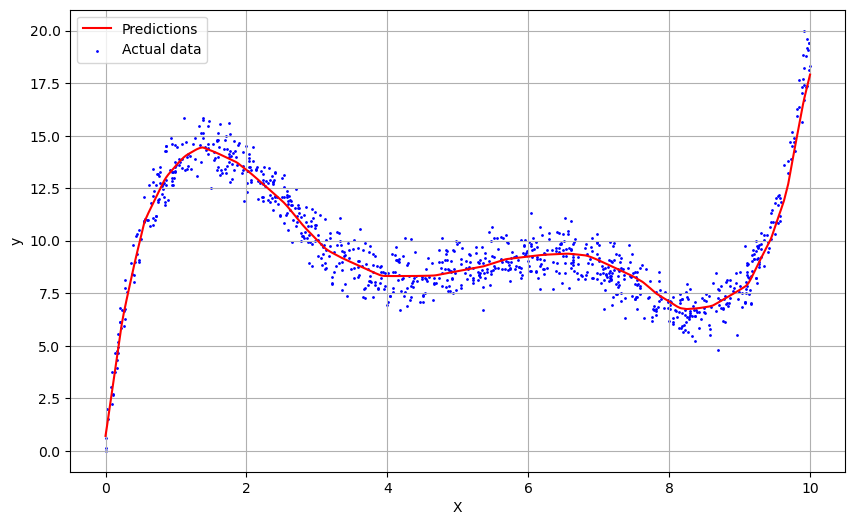

In [ ]:
model.eval();

tensor = torch.tensor(norm_X, dtype=torch.float32);

# Denormalize for plotting
predictions = model.forward(tensor).detach() * y_std + y_mean;

sortedIndices = tensor.flatten().argsort();
sorted_X = X[sortedIndices];
sortedPredictions = predictions[sortedIndices];

plt.figure(figsize=(10, 6));
plt.plot(sorted_X, sortedPredictions, color="red", label="Predictions");
plt.scatter(X, y, color="blue", label="Actual data", s=1);
plt.xlabel("X");
plt.ylabel("y");
plt.legend();
plt.grid();
plt.show();